### Importamos todo lo que usaremos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# **Procesamiento**

1. Cargar en un DataFrame los datos del archivo FBRef2020-21.csv

In [2]:
data = pd.read_csv("./FBRef2020-21.csv")
data.shape

(2823, 128)

2. Eliminar a los jugadores que jugaron menos de 500 minutos en la temporada (columna Min).


In [3]:
data = data[data["Min"]>=500]

3. Eliminar los datos faltantes. Por ejemplo, eliminar columnas con más de 100 datos faltantes y
luego las filas con datos faltantes, o convertir los datos faltantes a algún valor apropiado

In [4]:
columns = []
for column in data.columns:
    if data[column].isna().sum() >= 100:
        print(f"{column} :", data[column].isna().sum())
        columns.append(column)

SoT% : 140
Gls/Shot : 140
Gls/SoT : 298
AvgShotDist : 142
npxG/Shot : 142
DribSucc% : 117


In [5]:
# Eliminamos columnas con mas de 100 datos faltantes
data = data.drop(columns=columns)

In [6]:
# Veamos cuantas filas tienen datos faltantes
data[data.isna().any(axis=1)].shape[0]

60

In [7]:
print(f"Las filas con datos faltantes equivalen al {data[data.isna().any(axis=1)].shape[0]/data.shape[0]*100} %")

Las filas con datos faltantes equivalen al 3.058103975535168 %


In [8]:
data.dropna(inplace=True)

4. Al finalizar la limpieza de datos, resetear los indices.

In [9]:
data.reset_index(drop=True, inplace=True)

5. Definir el DataFrame data_num que solo contenga las variables númericas, a partir de la columna `Ast/90`, inclusive. Para clustering y clasificación no vamos a utilizar las variables categóricas ni edad ni minutos jugados.

In [10]:
# Me quedo solo con las numericas a partir de Ast/90
data_numerico = data.loc[:, "Ast/90":]


In [11]:
# Veamos el tipo de cada columna que no sea numerica
for column in data_numerico.columns:
    if data_numerico[column].dtype == "object":
        print(f"{column} : {data_numerico[column].dtype}")

%TchsDefPen : object
%TchsDefThrd : object
%TchsMidThrd : object
%TchsAttThrd : object
%TchsAttPen : object


Hay algunos que quedaron en object, veamoslos

In [12]:
data_numerico[["%TchsDefPen","%TchsDefThrd","%TchsMidThrd","%TchsAttThrd","%TchsAttPen"]]

,%TchsDefPen,%TchsDefThrd,%TchsMidThrd,%TchsAttThrd,%TchsAttPen
0,0.05431547619,0.306547619,0.4851190476,0.2604166667,0.0287202381
1,0.1336923077,0.5769230769,0.4723076923,0.01969230769,0.01
2,0.1653027823,0.6055646481,0.4320785597,0.02929623568,0.01865793781
3,0.06929674099,0.4065180103,0.5317324185,0.1260720412,0.01012006861
4,0.1458607096,0.5164257556,0.4914586071,0.08186596583,0.008015768725
...,...,...,...,...,...
1897,0.0137254902,0.1408496732,0.5261437908,0.4117647059,0.05
1898,0.007679180887,0.1155290102,0.4982935154,0.4658703072,0.06604095563
1899,0.02243186583,0.1192872117,0.4444444444,0.5303983229,0.08092243187
1900,0.01461716937,0.2044083527,0.3851508121,0.5104408353,0.08607888631


Lo transformamos a numerico

In [13]:
data_numerico["%TchsDefPen"] = pd.to_numeric(data_numerico["%TchsDefPen"])
data_numerico["%TchsDefThrd"] = pd.to_numeric(data_numerico["%TchsDefThrd"])
data_numerico["%TchsMidThrd"] = pd.to_numeric(data_numerico["%TchsMidThrd"])
data_numerico["%TchsAttThrd"] = pd.to_numeric(data_numerico["%TchsAttThrd"])
data_numerico["%TchsAttPen"] = pd.to_numeric(data_numerico["%TchsAttPen"])

In [14]:
for column in data_numerico.columns:
  if not (np.issubdtype(data_numerico[column].dtype, np.floating)):
    print("Hay una columna que no es float:", column)

Listo, todos en numerico.

# **Clustering**

### 6. Nuestro primer objetivo es realizar algún agrupamiento de jugadores con características similares

### (a) Seleccionar dos variables cualesquiera de los datos y realizar un gráfico de dispersión de una variable en función de la otra para el total de las observaciones. ¿Pueden encontrar fácilmente grupos distintos?

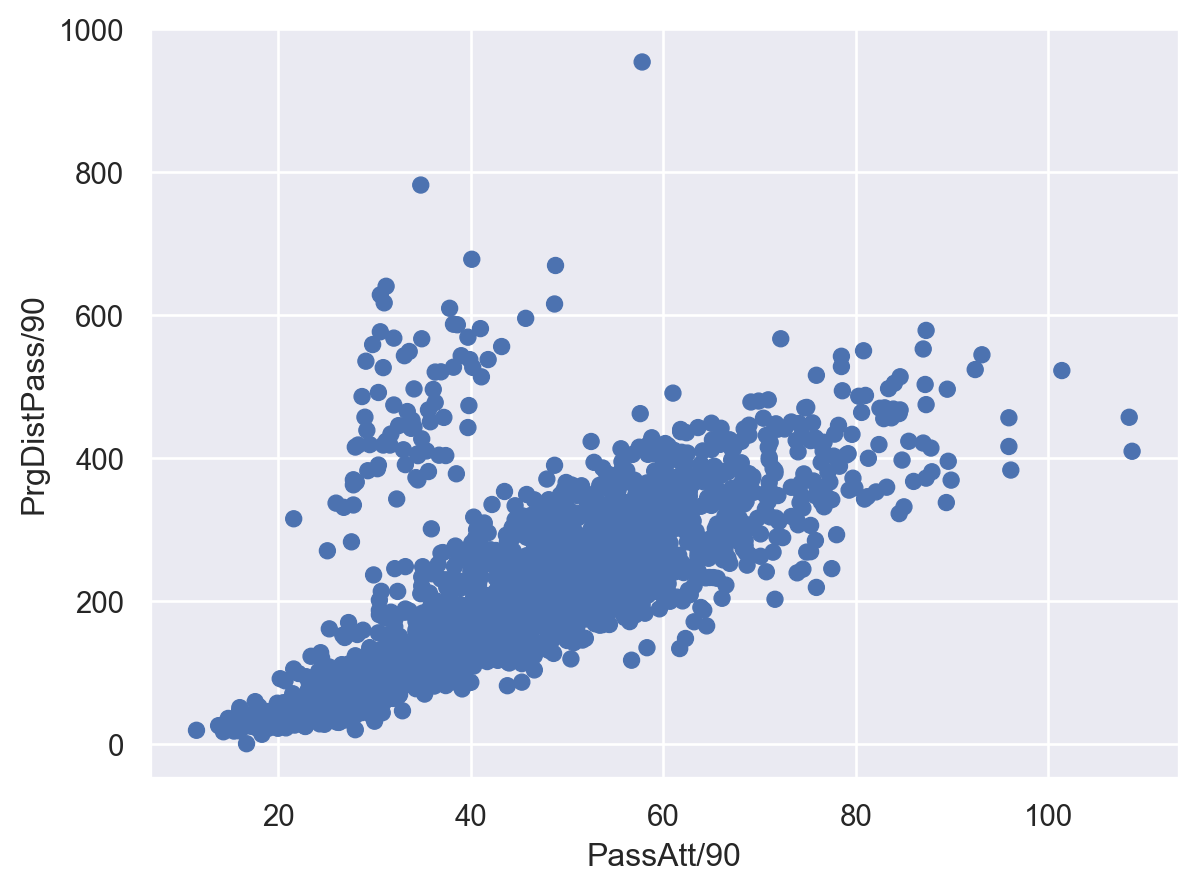

In [15]:
(
    so.Plot(data_numerico, y="PrgDistPass/90",x="PassAtt/90")
    .add(so.Dot())
)

#### Podemos observar dos grupos distintos, uno mucho mas concentrado y con una distribucion tipo lineal (amarillo), y otro menos disperso centrado mas a la izquierda (rojo). 


<img src="./imagen1.png" height=500>

### (b) Escalar los datos y realizar un análisis de componentes principales, quedándose solo con las dos primeras componentes. Realizar un grafico como el del punto anterior. ¿Cuantos clusters puede distinguir en el gráfico? ¿A que caracterısticas de los jugadores pueden corresponder los clusters? ¿Como pueden verificar su conjetura? (realizar una visualización o algún cálculo)


In [16]:
# Escalamos los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numerico)

data_scaled = pd.DataFrame(data_scaled, columns=data_numerico.columns)

In [17]:
# Calculamos la matriz de covarianza
cov_matrix = data_scaled.cov(ddof=0)

# Calculamos los autovalores y autovectores
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Ordenamos los autovalores de mayor a menor
idx = np.argsort(eigenvalues)[::-1]
autovalores_ordenados = eigenvalues[idx]
autovectores_ordenados = eigenvectors[:, idx]

# Calculamos la proporción de varianza explicada
varianza_explicada = autovalores_ordenados / np.sum(autovalores_ordenados)

# Calculamos la varianza explicada acumulada
varianza_acumulada = np.cumsum(varianza_explicada)


# Mostramos los resultados
print("\nVarianza acumulada:\n", varianza_acumulada)

print("\nPrimera componente principal:")
print("Porcentaje de variabilidad: ", varianza_explicada[0])

print("\nSegunda componente principal:")
print("Porcentaje de variabilidad: ", varianza_explicada[1])



Varianza acumulada:
 [0.28561673 0.49149036 0.57636699 0.64092278 0.67562032 0.70428414
 0.72733105 0.7454701  0.76006741 0.77333547 0.78589119 0.79731047
 0.8082866  0.81863817 0.82772291 0.83670823 0.8448864  0.85279187
 0.86036217 0.8675791  0.87436292 0.8807907  0.88682172 0.89254261
 0.89798179 0.90318931 0.9081094  0.91296955 0.91761099 0.92200102
 0.92625792 0.93042101 0.9342468  0.93803204 0.9415153  0.94478986
 0.94803218 0.95106106 0.95397782 0.9568699  0.95967974 0.96223506
 0.96467966 0.96693712 0.96908944 0.97120973 0.97329085 0.97514354
 0.9767824  0.97836204 0.97985918 0.98126844 0.98256659 0.98382434
 0.98494989 0.98603346 0.98706128 0.98805721 0.98899712 0.9898808
 0.99068812 0.9914528  0.99217501 0.99282739 0.99344117 0.99402324
 0.99457317 0.99510233 0.99560396 0.99605133 0.99646074 0.99685823
 0.99722154 0.99757447 0.99790701 0.99817076 0.99843051 0.99866876
 0.99889035 0.99910327 0.99927245 0.99943256 0.9995608  0.99965278
 0.99973318 0.99980239 0.99984966 0.99987

In [18]:
# Me quedo con las dos primeras componentes principales
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data_pca

array([[-2.72172986,  2.4562197 ],
       [-7.15401635, -0.92281616],
       [-6.98063265, -3.3786926 ],
       ...,
       [ 7.09056586,  0.91846771],
       [ 6.92208554, -1.47514622],
       [ 2.60596569,  2.10257454]])

In [19]:
data_pca = pd.DataFrame(data_pca, columns=["PC1", "PC2"])

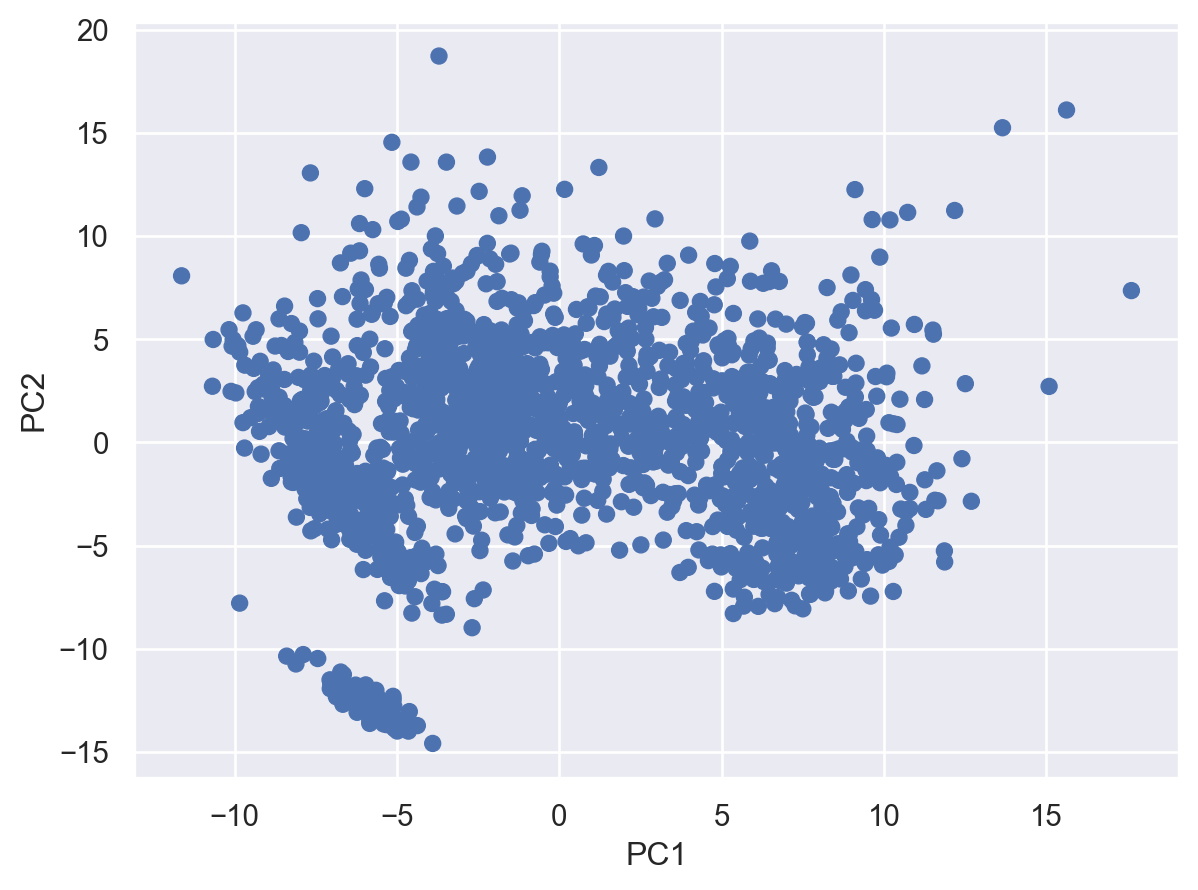

In [20]:
(
    so.Plot(data_pca, x="PC1", y="PC2")
    .add(so.Dot())
)

Podemos ver claramente 2 clusters, pero nos confunde en la izquierda parece ser que estan un poco separados dando a entender que quizas hay 3. Pero nos quedamos con que hay dos clusters

### (c) Para la cantidad de clusters observados en el ítem anterior, realizar un agrupamiento por k-medias, y colorear los puntos seg´un las etiquetas obtenidas. ¿Coinciden las etiquetas con lo esperado?

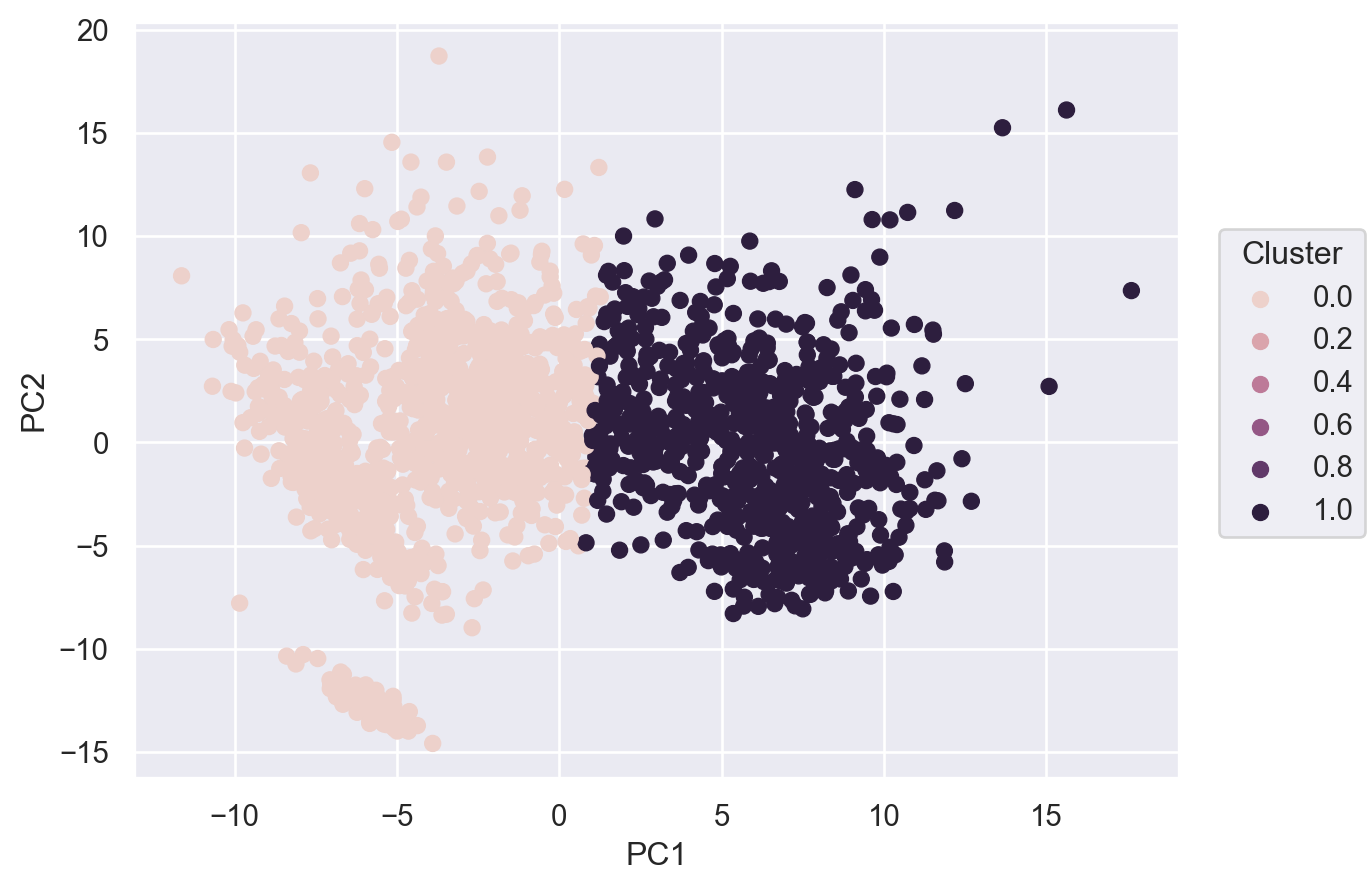

In [21]:
from sklearn.cluster import KMeans
# Aplicar K-Means para encontrar clusters
kmeans = KMeans(n_clusters=2, random_state=42,n_init=10)  # Puedes ajustar el número de clusters
data_pca['Cluster'] = kmeans.fit_predict(data_pca)

# Visualizar los clusters
(
    so.Plot(data_pca, x="PC1", y="PC2",color="Cluster")
    .add(so.Dot())
)

Lo que observamos no coincide con lo esperado.

### (d) Repetir el agrupamiento utilizando DBSCAN. ¿Como eligirıan en este caso un valor de ε apropiado? Sugerencia: consultar la seccion ”Seleccion del hiperparametro eps” del Notebook de la clase de DBSCAN (o utilizar cualquier otra t´ecnica que consideren apropiada)


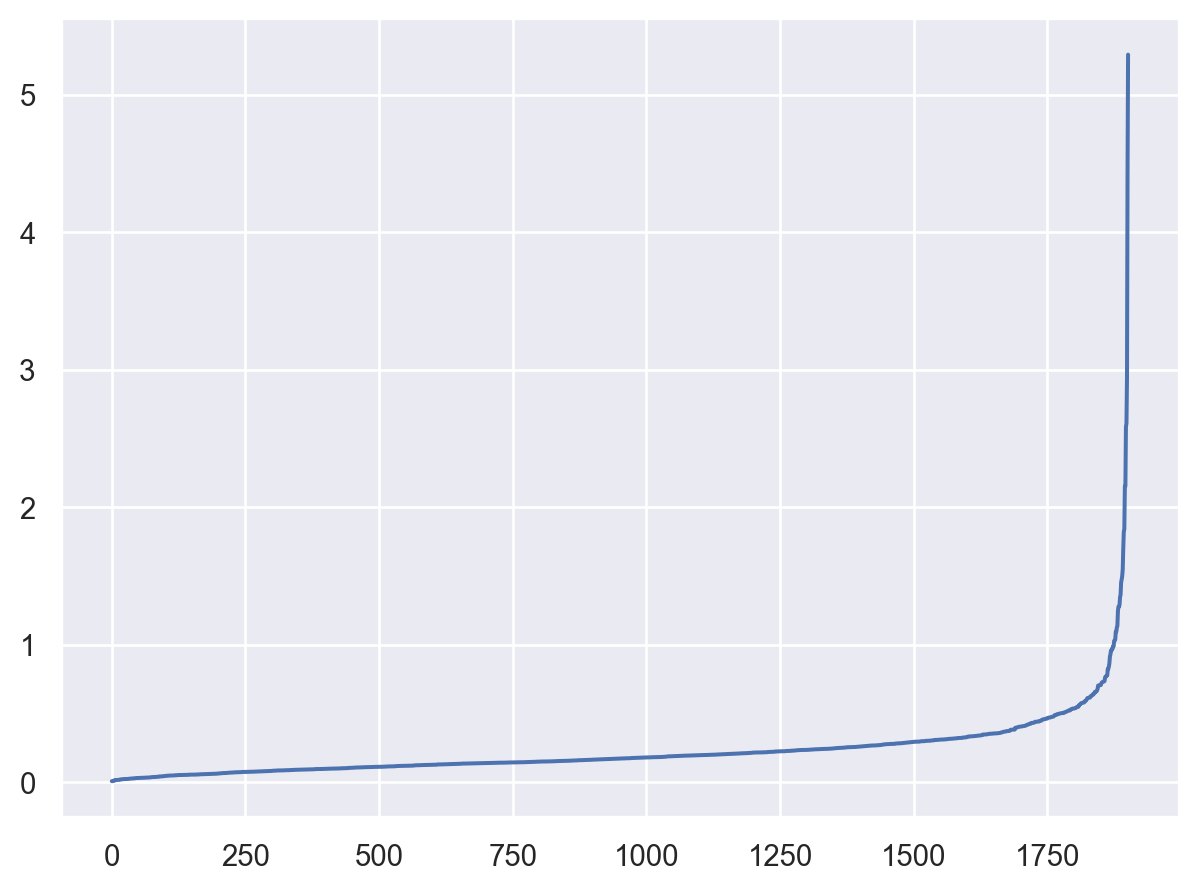

In [22]:
# Seleccion de hiperparametros
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=2)  
neighbors_fit = neighbors.fit(data_pca)

distances, indices = neighbors_fit.kneighbors(data_pca)
distances = distances[:,1]
distances = np.sort(distances, axis=0)

so.Plot(x = np.arange(len(distances)), y = distances).add(so.Line())


Elegimos el eps donde la curva hace el codo, que seria a nuestro criterio 0.75
Para la eleccion de min_samples (vecinos) vamos a ir probando de 2 a 10 hasta encontrar uno medianamente adecuado.

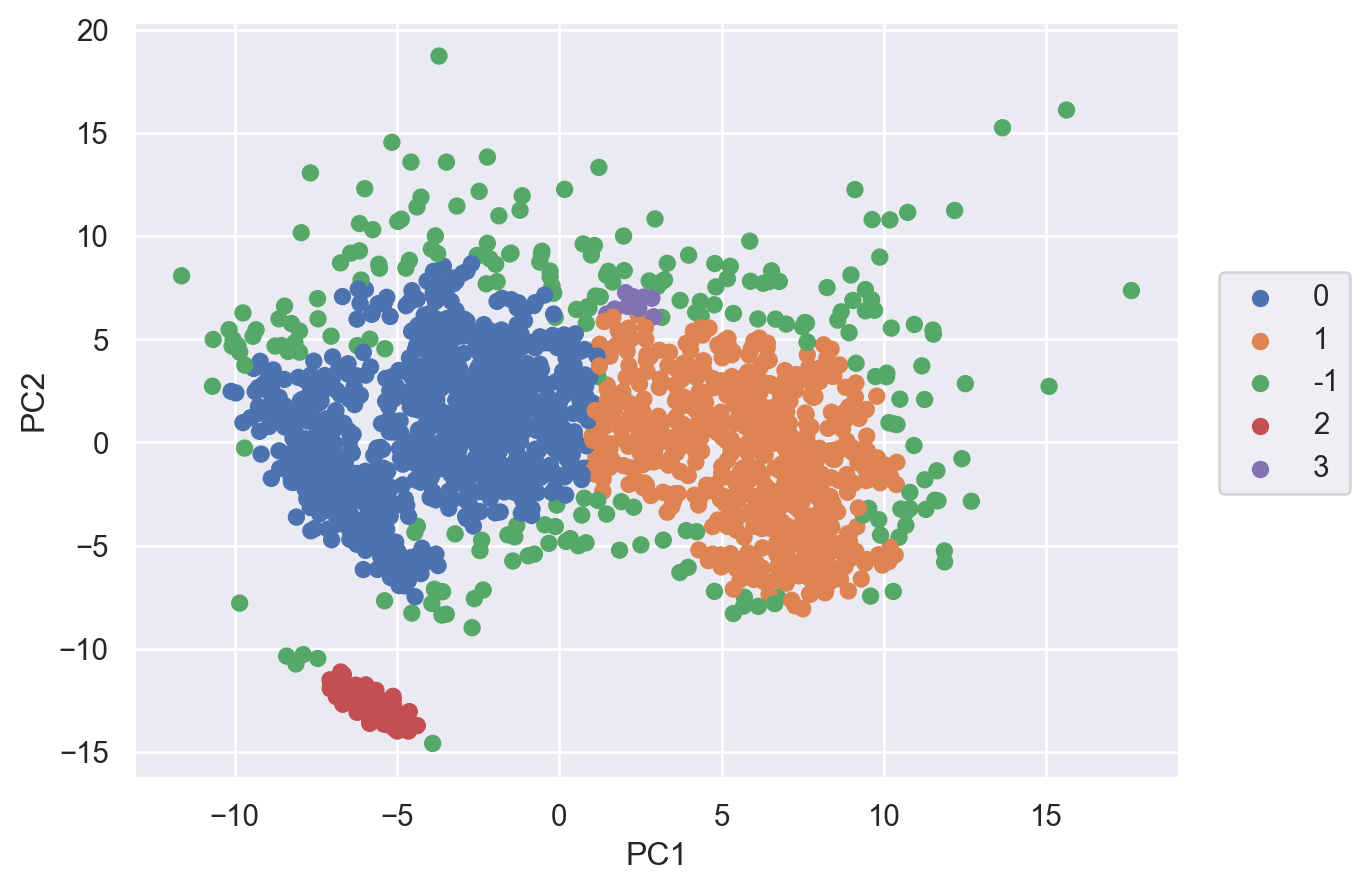

In [23]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.75, min_samples=8)
etiquetas = clustering.fit_predict(data_pca)

(
    so.Plot(data_pca, x="PC1", y="PC2",color=etiquetas.astype('str'))
    .add(so.Dot())
 )

De los dos graficos nos quedamos con este por que realmente separa el cluster rojo de los demas, ademas tambien separa un poco en el medio en dos clusters, si bien no como vimos al principio lo hace separandolos por la mitad.

### Volviendo un poco a la pregunta `(b)`
¿A que caracterısticas de los jugadores pueden corresponder los clusters? ¿Como pueden verificar su conjetura? (realizar una visualización o algún cálculo)

Vamos a agarrar los indices de los clusters en rojo y analizarlos

In [30]:
# Los cluster del grupo rojo son los de indice 2. Los seleccionamos
data_pca["Cluster"] = etiquetas

data_pca_rojos = data_pca[data_pca["Cluster"] == 2]

# Seleccionamos los indices y los ponemos en el dataset original
indices = data_pca_rojos.index
# Los vemos en el dataset original
data_cluster2 = data.loc[indices]
data_cluster2

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
1218,Alisson,br BRA,GK,Liverpool,eng Premier League,27.0,1992.0,33,33,2970,...,38.6,0.0,0.0,0.0,0.00,0.0,19.9,19.8,99.7,0.00
1219,Saturnin Allagbé,bj BEN,GK,Dijon,fr Ligue 1,26.0,1993.0,12,12,1080,...,31.9,0.0,0.0,0.0,0.00,0.0,14.3,14.3,99.4,0.00
1220,Alphonse Areola,fr FRA,GK,Fulham,eng Premier League,27.0,1993.0,36,36,3240,...,27.8,0.0,0.0,0.0,0.03,0.0,11.2,11.2,99.5,0.00
1221,Kepa Arrizabalaga,es ESP,GK,Chelsea,eng Premier League,25.0,1994.0,7,6,585,...,46.6,0.0,0.0,0.0,0.31,0.0,22.8,22.8,100.0,0.00
1222,Sergio Asenjo,es ESP,GK,Villarreal,es La Liga,31.0,1989.0,36,36,3240,...,47.2,0.0,0.0,0.0,0.00,0.0,19.6,19.4,99.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,Thomas Strakosha,al ALB,GK,Lazio,it Serie A,25.0,1995.0,9,9,810,...,89.3,0.0,0.0,0.0,0.00,0.0,23.6,23.1,98.1,0.00
1294,Marc-André ter Stegen,de GER,GK,Barcelona,es La Liga,28.0,1992.0,31,31,2790,...,44.5,0.0,0.0,0.0,0.00,0.0,20.6,20.5,99.5,0.00
1295,Kevin Trapp,de GER,GK,Eint Frankfurt,de Bundesliga,30.0,1990.0,33,33,2970,...,51.0,0.0,0.0,0.0,0.00,0.0,22.6,22.6,99.7,0.00
1296,Iván Villar,es ESP,GK,Celta Vigo,es La Liga,23.0,1997.0,21,19,1781,...,45.6,0.0,0.0,0.0,0.00,0.0,15.1,14.9,99.3,0.00


In [31]:
# Notemos que en Pos parece que solo aparece GK
data_cluster2["Pos"].value_counts()

GK    75
Name: Pos, dtype: int64

Entonces, respondiendo a la pregunta, ese cluster en particular resulta de que los jugadores son los arqueros (lo cual tiene sentido pues tienen reglas distintas, como agarrarla con la mano en el area, y estadisticas distintas a otros jugadores de campo), por ejemplo, goles o asistencias. 

# **CLASIFICACIÓN**

### 7. Ahora queremos poder predecir la posicion en la que juega cada jugador segun sus datos estadisticos utilizando KNN. En la columna Pos encontramos la posicion de los jugadores. Para la mayorıa de los jugadores se indica una  ́unica posicion pero algunos jugadores tienen dos posiciones. Para simplificar el analisis vamos a considerar una unica posicion por jugador 

### a) Definir la variable `Pos_filt` que es la columna `Pos`, pero donde los jugadores deben tener una sola posicion (pueden quedarse solo con la primera posici´on de cada jugador o eliminar los jugadores con dos posiciones, lo que consideren m´as conveniente)

In [35]:
contador = 0
for pos in data["Pos"]:
    if len(pos.split(","))>1:
        contador += 1
print(f"La cantidad de posiciones diferentes es de {contador}, que representa el {contador/data.shape[0]*100} %")

La cantidad de posiciones diferentes es de 490, que representa el 25.76235541535226 %


Decidimos que en vez de dropear el 25% vamos a quedarnos con la primera posicion con la que aparece el jugador.

In [36]:
Pos_filt= data['Pos'].apply(lambda x: x.split(",")[0])
print(Pos_filt)

0       DF
1       DF
2       DF
3       DF
4       DF
        ..
1897    MF
1898    MF
1899    MF
1900    MF
1901    MF
Name: Pos, Length: 1902, dtype: object


### (b) Construir el DataFrame `data_clasif` que resulta de agregarle la columna de `Pos_filt` al DataFrame `data_num`. Dividir `data_num` en un 80% para entrenamiento y un 20% para testeo 
# CONSULTAR -> dividir data num o data clasif? Me parece que es data_clasif

In [54]:
data_clasif= data_numerico.copy()
data_clasif['Pos_filt']= Pos_filt

# Separamos las variables
X = data_clasif.drop(columns=["Pos_filt"]) # Variables predictoras
y = data_clasif["Pos_filt"] # Variable objetivo

#Dividimos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### (c) Aplicar un esquema de validación en el conjunto de entrenamiento para seleccionar el valor optimo de K. (Esto puede demorar mucho si prueban muchos valores de K, pueden hacerlo hasta un valor maximo de K = 20.)
Sugerencia: puede resultar de ayuda `KNeighborsClassifier` de sklearn e investigar esa libreıa para aplicar esquemas de validacion

El mejor valor de k es: 7
El accuracy de k es: 0.8409055727554179


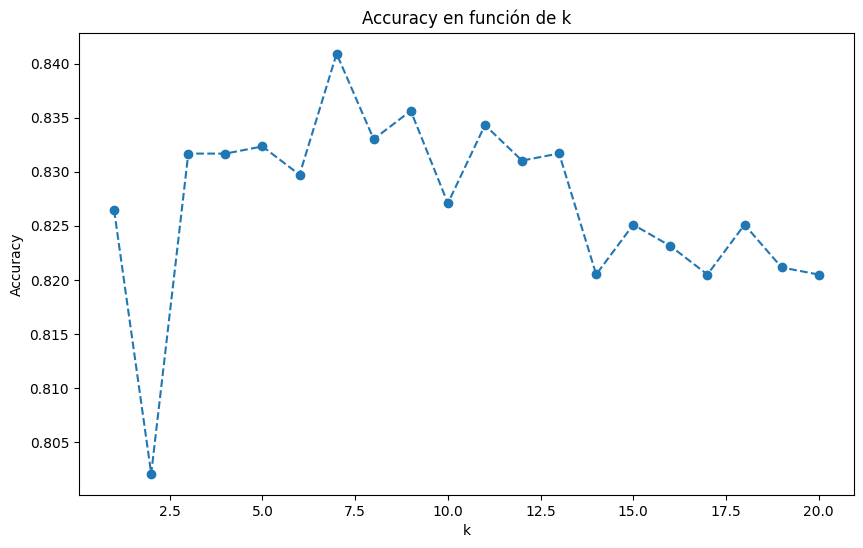

In [55]:
# Vamos a hacer un esquema de validacion cruzada para elegir el optimo k
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Probamos con k en rango de 1 a 20
from sklearn.neighbors import KNeighborsClassifier
resultados = []
for k in range(1, 21):
    modelo = KNeighborsClassifier(n_neighbors=k)
    resultados.append(cross_val_score(modelo, X_train, y_train, cv=kfold, scoring="accuracy").mean())

# Encuentra el valor de k con el puntaje más alto
best_k = np.argmax(resultados) + 1
print("El mejor valor de k es:", best_k)
print("El accuracy de k es:", resultados[best_k-1])

# Graficamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), resultados, marker="o", linestyle="--")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy en función de k")
plt.show()


El mejor valor de k es: 17
El accuracy de k es: 0.9165118679050567


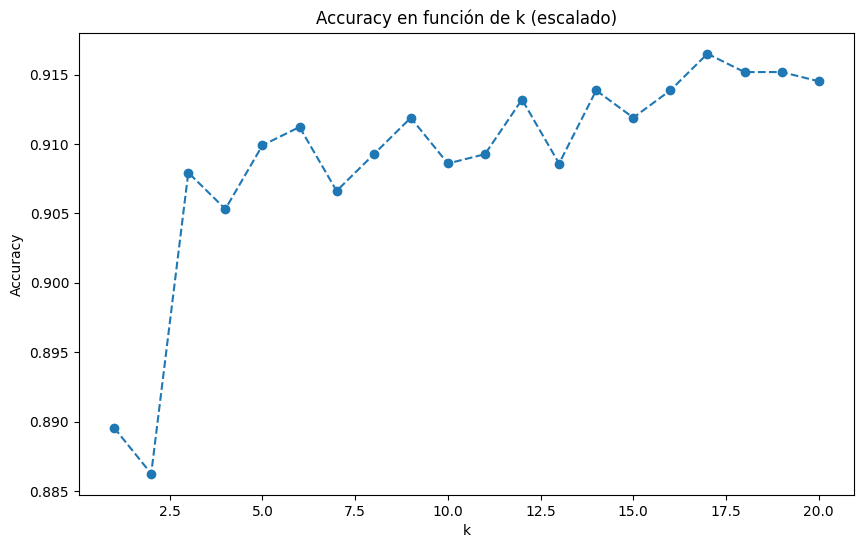

In [56]:
# Ahora hacemos lo mismo pero escalando los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

resultados = []
for k in range(1, 21):
    modelo = KNeighborsClassifier(n_neighbors=k)
    resultados.append(cross_val_score(modelo, X_train_scaled, y_train, cv=kfold, scoring="accuracy").mean())

# Encuentra el valor de k con el puntaje más alto
best_k = np.argmax(resultados) + 1
print("El mejor valor de k es:", best_k)
print("El accuracy de k es:", resultados[best_k-1])

# Graficamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), resultados, marker="o", linestyle="--")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy en función de k (escalado)")
plt.show()

#### El mejor valor de k es 17 si escalamos los datos y 7 si no, con un accuracy de 0.91 y 0.84 respectivamente.

### (d) Para el valor de K obtenido, ¿cual es el porcentaje de aciertos en el conjunto de testeo?

In [62]:
# Entrenamos el modelo con el mejor k
modelo = KNeighborsClassifier(n_neighbors=17)
modelo.fit(X_train_scaled, y_train)

# Predecimos en el conjunto de test
y_pred = modelo.predict(X_test_scaled)

# Calculamos la exactitud
from sklearn.metrics import accuracy_score
print("El porcentaje de aciertos en el conjunto de testeo es: ",accuracy_score(y_test, y_pred))

El porcentaje de aciertos en el conjunto de testeo es:  0.9238845144356955


In [68]:
# Entrenamos el modelo con el mejor k sin escalar
modelo = KNeighborsClassifier(n_neighbors=7)
modelo.fit(X_train, y_train)

# Predecimos en el conjunto de test
y_pred = modelo.predict(X_test)

# Calculamos la exactitud
from sklearn.metrics import accuracy_score
print("El porcentaje de aciertos en el conjunto de testeo es: ",accuracy_score(y_test, y_pred))

El porcentaje de aciertos en el conjunto de testeo es:  0.8162729658792651


### (e) Repetir el procedimiento utilizando la primeras dos componentes principales en vez de todas las variables. Indicar si se obtienen mejores resultados

El mejor valor de k es: 18
El accuracy de k es: 0.7409657722738218


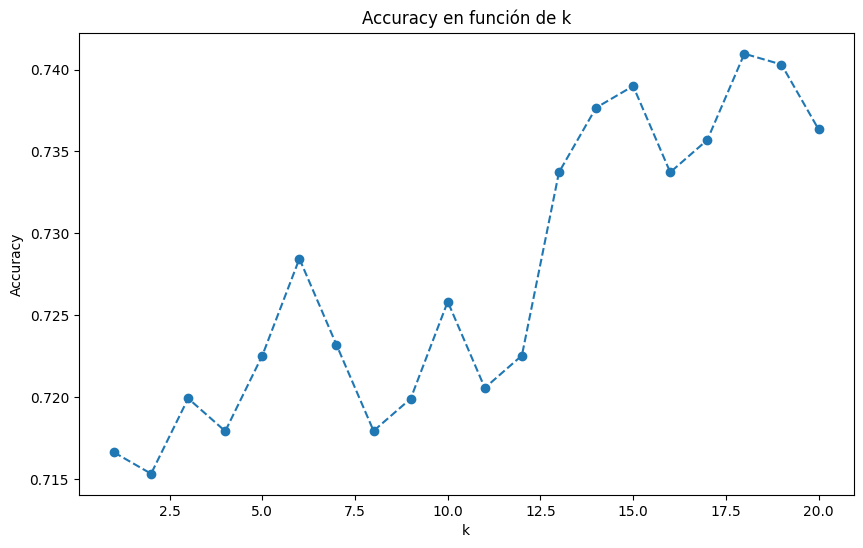

In [52]:
# Hacemos lo mismo pero con data_pca

# Separamos las variables
X = data_pca.drop(columns=["Cluster"]) # Variables predictoras
# y sigue siendo el mismo, con los mismos indices pues no se ha modificado

#Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

resultados = []
for k in range(1, 21):
    modelo = KNeighborsClassifier(n_neighbors=k)
    resultados.append(cross_val_score(modelo, X_train, y_train, cv=kfold, scoring="accuracy").mean())

# Encuentra el valor de k con el puntaje más alto
best_k = np.argmax(resultados) + 1
print("El mejor valor de k es:", best_k)
print("El accuracy de k es:", resultados[best_k-1])

# Graficamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), resultados, marker="o", linestyle="--")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy en función de k")
plt.show()

# Tengo que escalar otra vez? flaco ayudame